<a href="https://colab.research.google.com/github/asobolev/sberpy/blob/main/SBER_gender_exercise_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
# на основе
# https://www.tensorflow.org/tutorials/load_data/csv
# https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

import tensorflow as tf
import pandas as pd
import numpy as np
import functools
import requests

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [179]:
# загружаем данные с гугл диска
gender_train = pd.read_csv('https://storage.googleapis.com/asobolev-assets/gender_train.csv')
gender_test = pd.read_csv('https://storage.googleapis.com/asobolev-assets/gender_test.csv')
transactions = pd.read_csv('https://storage.googleapis.com/asobolev-assets/transactions.csv')

In [180]:
print('Количество клиентов: %s' % pd.unique(transactions['customer_id']).size)
print('Из них известен пол: %s' % gender_train.size)
print('Неизвестен пол: %s' % gender_test.size)

Количество клиентов: 15000
Из них известен пол: 16800
Неизвестен пол: 3600


In [181]:
# преобразуем транзакции:
# term_id не используем т.к. по идее пол не должен зависеть от терминала
transactions.pop('term_id')

# из время транзакции берем только час
transactions['tr_hour'] = transactions['tr_datetime'].apply(lambda x: int(x.split(' ')[1].split(':')[0]))
# и день (по модулю 7 - как бы день недели), остальное не информативно
transactions['tr_day'] = transactions['tr_datetime'].apply(lambda x: int(x.split(' ')[0]) % 7)

transactions.drop(columns=['tr_datetime'], inplace=True)
transactions.head()

,customer_id,mcc_code,tr_type,amount,tr_hour,tr_day
0,39026145,4814,1030,-2245.92,10,0
1,39026145,6011,7010,56147.89,10,1
2,39026145,4829,2330,-56147.89,10,1
3,39026145,5499,1010,-1392.47,10,1
4,39026145,5499,1010,-920.83,15,2


In [182]:
# известный пол - для тренировки сети
df_train = pd.merge(transactions, gender_train, on='customer_id', how='inner')

# неизвестный пол - для прогноза
df_test = pd.merge(transactions, gender_test, on='customer_id', how='inner')

In [235]:
# собираем векторы фич по статистике транзакций каждого клиента
def build_feature_vectors(df):
    features = []

    df_i = df[(df['amount'] > 0)]  # поступления
    df_e = df[(df['amount'] < 0)]  # расходы

    # первым идет баланс (есть у каждого клиента, должен быть вначале)
    balance = df.groupby('customer_id')['amount'].agg(['sum']).rename(columns={'sum': 'balance'})
    features += [balance]

    # max, median, std, sum расходов и поступлений (2x4)
    for metric in ('max', 'median', 'std', 'sum'):
      f1 = df_i.groupby('customer_id')['amount'].agg([metric])\
            .rename(columns={metric: 'inc_%s_total' % metric})
      f2 = df_e.groupby('customer_id')['amount'].agg([metric])\
            .rename(columns={metric: 'exp_%s_total' % metric})
      features += [f1, f2]

    # sum и median поступлений по часам (24x2)
    for hour in range(24):
      f1 = df_i[df_i['tr_hour'] == hour].groupby('customer_id')['amount'].agg(['sum'])\
            .rename(columns={'sum': 'inc_sum_hour_%s' % hour})
      f2 = df_i[df_i['tr_hour'] == hour].groupby('customer_id')['amount'].agg(['median'])\
            .rename(columns={'median': 'inc_med_hour_%s' % hour})
      features += [f1, f2]

    # медианы расходов по каждой MCC категории (1x184)
    f1 = df_e.groupby(['customer_id', 'mcc_code'])['amount'].agg(['median'])\
          .unstack(-1)['median']
    features.append(f1)

    # процент от общих расходов по каждой MCC категории (1x184)
    f1 = df_e.groupby(['customer_id', 'mcc_code'])['amount'].agg(['sum'])\
          .unstack(-1)['sum']  # суммы расходов по каждой категории
    f2 = df_e.groupby(['customer_id'])['amount'].agg(['sum'])['sum']  # суммы расходов вообще
    features.append(f1.divide(f2, axis=0))

    # sum и median расходов по дням недели (7x2)
    for day in range(7):
      f1 = df_e[df_e['tr_day'] == day].groupby('customer_id')['amount'].agg(['median'])\
            .rename(columns={'median': 'exp_med_day_%s' % day})
      f2 = df_e[df_e['tr_day'] == day].groupby('customer_id')['amount'].agg(['sum'])\
            .rename(columns={'sum': 'exp_sum_day_%s' % day})
      features += [f1, f2]

    # собираем все в одну таблицу
    dataset = functools.reduce(lambda x, y: pd.merge(x, y, on='customer_id', how='left'), features)
    dataset.fillna(0.0, inplace=True)

    # количество векторов фич должно быть равно количеству клиентов
    assert dataset.shape[0] == pd.unique(df['customer_id']).size

    return dataset

features_train = build_feature_vectors(df_train)
features_test = build_feature_vectors(df_test)

print('Размер вектора фич - %s' % features_train.shape[1])

Размер вектора фич - 439


In [236]:
# add PCA?
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# https://www.datacamp.com/community/tutorials/principal-component-analysis-in-python

In [237]:
# добавим к тренировочным фичам лейблы
df = pd.merge(features_train, gender_train, on='customer_id', how='inner')
df.drop(columns=['customer_id'], inplace=True)

# разделяем транзакции на тренировочные и проверочные
df_ev = df.sample(frac=0.1)
df_tr = df.drop(df_ev.index)

labels_tr = df_tr.pop('gender')
labels_ev = df_ev.pop('gender')

print("Выборка из %d строк для тренировки и %d для проверки" % (len(df_tr), len(df_ev)))

Выборка из 7560 строк для тренировки и 840 для проверки


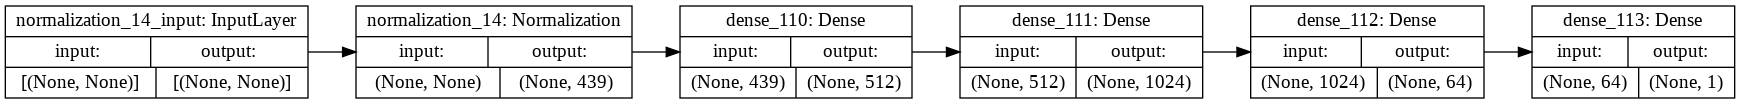

In [238]:
# слой сети для нормализации векторных фич
normalize = Normalization()
normalize.adapt(df_tr.to_numpy())

# модель сети
model = tf.keras.Sequential([
  normalize,
  layers.Dense(512, activation='sigmoid', input_dim=df_tr.shape[1]),
  layers.Dense(1024, activation='sigmoid'),
  layers.Dense(64, activation='sigmoid'),
  layers.Dense(1, activation='sigmoid')
])

#model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics=["accuracy"])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [239]:
model.fit(df_tr, labels_tr, epochs=15)

Epoch 1/15
237/237 [==============================] - 4s 14ms/step - loss: 0.6492 - auc_13: 0.6451
Epoch 2/15
237/237 [==============================] - 3s 14ms/step - loss: 0.5004 - auc_13: 0.8314
Epoch 3/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4826 - auc_13: 0.8438
Epoch 4/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4783 - auc_13: 0.8490
Epoch 5/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4739 - auc_13: 0.8509
Epoch 6/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4607 - auc_13: 0.8603
Epoch 7/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4515 - auc_13: 0.8651
Epoch 8/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4352 - auc_13: 0.8730
Epoch 9/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4371 - auc_13: 0.8725
Epoch 10/15
237/237 [==============================] - 3s 13ms/step - loss: 0.4080 - auc_13: 0.8893
Epoch 11/

In [240]:
# тест насколько хорошо получилась сеть
model.evaluate(df_ev, labels_ev)

27/27 [==============================] - 0s 4ms/step - loss: 0.5842 - auc_13: 0.8146


[0.5841642618179321, 0.8146273493766785]

In [241]:
# делаем прогноз
predictions = model.predict(features_test)

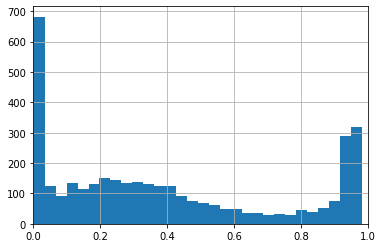

In [242]:
# смотрим на качество распределения вероятностных оценок 
# (расстраиваемся что много "трансгендеров" посередине)
import matplotlib.pyplot as plt 
plt.hist(predictions, 30)
plt.xlim(0, 1)
plt.grid()

In [243]:
submission = gender_test.copy()
submission['probability'] = predictions
submission.head()

,customer_id,probability
0,75562265,0.229397
1,84816985,0.326785
2,54129921,0.097786
3,23160845,0.002356
4,45646491,0.979749
